# Foundations of Data Mining: Fashion-MNIST Challenge

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

**Name:** Koen Klaren

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 200 # This controls the size of your figures
plt.rcParams['savefig.dpi'] = 200 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
# InteractiveShell.ast_node_interactivity = "all" 
import sklearn.decomposition as deco
from sklearn.cluster import KMeans 
from sklearn.metrics import confusion_matrix

## Fashion-MNIST
The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

In [2]:
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [3]:
fmnist_data = oml.datasets.get_dataset(40996) # Download MNIST data
# Get the predictors X and the labels y
X, y = fmnist_data.get_data(target=fmnist_data.default_target_attribute); 

In [8]:
# build a list of figures for plotting
def buildFigureList(fig, subfiglist, titles, length):
    
    for i in range(0,length):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(1,length,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.set_title(titles[i])
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

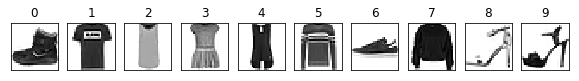

In [9]:
subfiglist = []
titles=[]

for i in range(0,10):
    subfiglist.append(X[i])
    titles.append(i)

buildFigureList(plt.figure(1, figsize=(10,2)),subfiglist, titles, 10)
plt.show()

## Question 2. Analyzing image data with neural embedding

*In this part of the assignment, rather than working on the whole dataset you will implement representation learning on one part of the data and analyze the second part of the data with the learned representations.*

Use the provided code to split the training dataset in two subset based on their class labels. Dataset 1, containing classes 0 to 4 and Dataset 2 classes 5 to 9. 

### a ) Develop a model for learning representations (4 points)

Develop a convolutional neural network model for classification on Dataset 1 using the Keras python library.

You are free to choose your model architecture such that:
- You need to justify the decisions for selecting the layers, activation functions and loss function. (Add a text cell where you can write your justification)
- Your model must have one dense layer with 64 neurons and ReLU activation that is not the first nor the last layer in the model. We will refer to this layer as a 'neural code' (set **name='neural_codes'** parameter in your code for that layer).


In [10]:
# Do not modify this cell
# Extra imports for kears layers, matplotlib and nearestneigbors
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

Using TensorFlow backend.


In [11]:
## Do not modify this cell
# Load and reshape the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

x_train = X
y_train = y

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    #x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    #x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

    y_train = to_categorical(y_train, n_classes)

    
# Split the data in two datasets 
indexes1 = np.where(np.argmax(y_train, axis=1) <= 4)
indexes2 = np.where(np.argmax(y_train, axis=1) > 4)
dataset_1 = x_train[indexes1]
y_dataset1 = y_train[indexes1]
dataset_2 = x_train[indexes2]
y_dataset2 = y_train[indexes2]

print ("Dataset 1 shape: ", dataset_1.shape)    
print ("Dataset 2 shape: ", dataset_2.shape)    
print("Dataset 1 labels shape: ", y_dataset1.shape)
print("Dataset 2 labels shape: ", y_dataset2.shape)


Dataset 1 shape:  (35000, 28, 28, 1)
Dataset 2 shape:  (35000, 28, 28, 1)
Dataset 1 labels shape:  (35000, 10)
Dataset 2 labels shape:  (35000, 10)


In [76]:
# Implement your model here

model = Sequential()

model.add(Conv2D(6, (5, 5), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu', name='neural_codes'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 10, 10, 16)        880       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 400)               0         
_________________________________________________________________
neural_codes (Dense)         (None, 64)                25664     
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
__________

In [34]:
# Do not modify this cell
# Execute this cell before training!
# This is the model for extracting the image neural codes from the trained model
neural_codes_model = Model(inputs=model.input, outputs=model.get_layer("neural_codes").output)

In [77]:
# Trainning loop 
# given parameters are just a suggestion
batch_size = 64
epochs = 10

model.fit(dataset_1, y_dataset1,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/10
31500/31500 [==============================] - 9s 271us/step - loss: 3.1407 - acc: 0.5997 - val_loss: 0.4899 - val_acc: 0.8154
Epoch 2/10
31500/31500 [==============================] - 7s 233us/step - loss: 0.5479 - acc: 0.7918 - val_loss: 0.4110 - val_acc: 0.8309
Epoch 3/10
31500/31500 [==============================] - 7s 235us/step - loss: 0.4545 - acc: 0.8318 - val_loss: 0.3724 - val_acc: 0.8694
Epoch 4/10
31500/31500 [==============================] - 8s 243us/step - loss: 0.4113 - acc: 0.8519 - val_loss: 0.3409 - val_acc: 0.8883
Epoch 5/10
31500/31500 [==============================] - 8s 264us/step - loss: 0.3721 - acc: 0.8614 - val_loss: 0.3247 - val_acc: 0.8891
Epoch 6/10
31500/31500 [==============================] - 8s 246us/step - loss: 0.3494 - acc: 0.8732 - val_loss: 0.3084 - val_acc: 0.8937
Epoch 7/10
31500/31500 [==============================] - 8s 256us/step - loss: 0.3366 - acc: 0.8770 - val_loss: 0.2990 - v

#### Model justification

The model consists of two sections: the Convolutional and Dense sections. The convolutional section is based of the architecture from the lectures: (Conv -> ReLU -> MaxPool) repeated. I have tried various configurations (e.g. additional Conv layers, a Dropout layer, or dropping some MaxPool layers) and parameters (filter and kernel size of the convolutional layers). Then a Flatten layer going into the Dense section. The first Dense layer is the required 'neural codes' layer. This is followed by a Dropout layer to improve generalization. Finally I added a Dense layer with a node for each target class and softmax activation so we get probability-like values for each class. For the loss function I used categorical cross entropy as this is typical for classification problems with multiple classes, like FMNIST.


### b) Generate neural codes (1 point) 
Process all the images from Data set 2 with the trained model from **a)** and save the activations from the 'neural code' layer 

In [ ]:
# Implement here
# Note: Using neural_codes_model compute the neural code for the images in dataset_2 



### c) Analyze the neural codes (3 points) 

Implement the following analysis of the neural codes computed in ** b) **:

- Compute and show the mean and the first two principle components as images (see note below)
- Make a 2-dimensional scatter plot of the transformed data
- Compute and show a small number of samples along each of the two main axes as images
- Compare the results of this analysis with the results of the analysis in part one where you worked on the data in the high dimensional (image) space. 

*Note: To produce an image from a arbitrary neural code use nearest neighbor to find the closest neural code from the training dataset (code is provided in the next cell)* 

In [ ]:
# Do not modify this cell
# This code will give you a method for getting the index of the closest neural code neighbor 
# (see example code in the next cell)
neigh = NearestNeighbors(n_neighbors=5, p=2)
neigh.fit(neural_codes)

def get_closest_neighbor(code):
    distances, indexes = neigh.kneighbors([code])
    return indexes[0, 1]


In [ ]:
# Example code for finding a neighbors based on the neural codes 

# Select a random image from the dataset 
index = 123
# Get its neural code
print("Neural code: ", neural_codes[index])
# Get its closest neighbor
index_neighbor = get_closest_neighbor(neural_codes[index])

# Build the figure
subfiglist = []
titles = []
subfiglist.append(np.squeeze(dataset_2[index], axis=2))
titles.append(fmnist_classes[np.argmax(y_dataset2[index])])
subfiglist.append(np.squeeze(dataset_2[index_neighbor], axis=2))
titles.append(fmnist_classes[np.argmax(y_dataset2[index_neighbor])])

buildFigureList(plt.figure(1),subfiglist, titles, 2)

In [ ]:
# Develop solution here


### d) Analyze a cluster computed by k-means (2 Points)
- Run k-means on neural code from Dataset 2 with k=5 using k-means++ and random_state=0
- Compute and show a confusion matrix of the clusters with respect to the original labels.